In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import pickle

# Read in pickled data frames

pickle_in = open("train.pickle", "rb") # read file as bytes
train = pickle.load(pickle_in)

pickle_in = open("test.pickle", "rb") # read file as bytes
test = pickle.load(pickle_in)

pickle_in = open("RUL_df.pickle", "rb") # read file as bytes
RUL_df = pickle.load(pickle_in)
RUL_df = pd.DataFrame(RUL_df)

train.head()

,unit_number,cycles,operational_setting_1,operational_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21,maxcycles,RUL,20_cycles_to_failure
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,...,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,192,191,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,...,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,192,190,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,...,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,192,189,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,...,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,192,188,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,...,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,192,187,0


In [3]:
target_count = train['20_cycles_to_failure'].value_counts()

# Print class balance

print(f"Class 0: 'Normal': {target_count[0]}")
print(f"Class 1: 'Near Failure': {target_count[1]}")
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 'Normal': 18531
Class 1: 'Near Failure': 2100
Proportion: 8.82 : 1
Percentage of Majority Class: 89.82


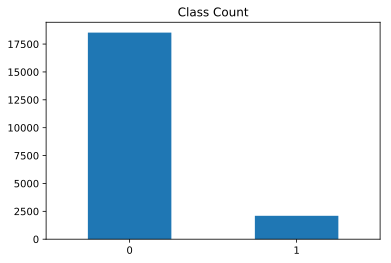

In [4]:
target_count.plot(kind='bar', title='Class Count', rot=0);

In [5]:
target_count_test = RUL_df['20_cycles_to_failure'].value_counts()

# Print class balance

print(f"Test Class 0: 'Normal': {target_count_test[0]}")
print(f"Test Class 1: 'Near Failure': {target_count_test[1]}")
print(f'Proportion: {round(target_count_test[0] / target_count_test[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count_test[0] / sum(target_count_test), 4)*100}')

Test Class 0: 'Normal': 84
Test Class 1: 'Near Failure': 16
Proportion: 5.25 : 1
Percentage of Majority Class: 84.0


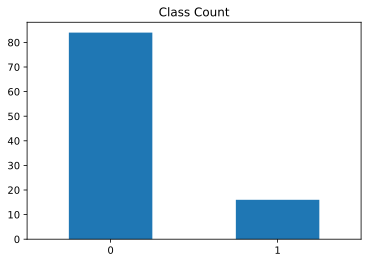

In [6]:
target_count_test.plot(kind='bar', title='Class Count', rot=0);

NOTE:  The "Metric Trap" is a result of training for accuracy. If the dataset has 1% of the data in class 1, we can predict class 0 **all the time** and get an accuracy of 99%!

In [7]:
# Before oversampling to balance our label classes let's see how well we can classify with unbalanced training data

X = train.drop(columns=['unit_number', 'maxcycles', 'RUL', '20_cycles_to_failure'], axis=1)
y = train['20_cycles_to_failure']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 0 to 20630
Data columns (total 17 columns):
cycles                   20631 non-null int64
operational_setting_1    20631 non-null float64
operational_setting_2    20631 non-null float64
sensor_measurement_2     20631 non-null float64
sensor_measurement_3     20631 non-null float64
sensor_measurement_4     20631 non-null float64
sensor_measurement_7     20631 non-null float64
sensor_measurement_8     20631 non-null float64
sensor_measurement_9     20631 non-null float64
sensor_measurement_11    20631 non-null float64
sensor_measurement_12    20631 non-null float64
sensor_measurement_13    20631 non-null float64
sensor_measurement_14    20631 non-null float64
sensor_measurement_15    20631 non-null float64
sensor_measurement_17    20631 non-null int64
sensor_measurement_20    20631 non-null float64
sensor_measurement_21    20631 non-null float64
dtypes: float64(15), int64(2)
memory usage: 2.8 MB


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

def hyperparameter_grid_search(X, y, models, hyperparameter_grid, scoring):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    best_list = []
    
    for model, params in list(zip(models.values(), hyperparameter_grid.values())):
        rand = RandomizedSearchCV(model, params, cv=5, scoring=scoring, random_state=42)
        rand.fit(X_train_scaled, y_train)
        best_list.append([model, rand.best_params_,  rand.best_score_])
        
    return best_list

In [9]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

classification_models = {
    'K-Nearest Neighbors Classifier': KNeighborsClassifier(),
    'Support Vector Classifier': SVC(),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42)
}

hyperparameter_grid = {
    'K-Nearest Neighbors Classifier': {'n_neighbors': [num for num in list(range(1,21))]},
    'Support Vector Classifier': {'kernel':['rbf', 'poly'], 'C': list(range(1,10)), 
                                  'gamma': list(np.linspace(0.01,0.1,10))}, 
    'Decision Tree Classifier': {'max_depth': list(range(1,5))},
    'Random Forest Classifier': {'max_depth': list(range(1,5)), 'n_estimators': list(range(1,100))}, 
    'Gradient Boosting Classifier': {'learning_rate':list(np.linspace(0.01,0.1,10)), 'max_depth':list(range(1,5))}
}

hyperparameter_grid_search(X, y, classification_models, hyperparameter_grid, scoring='f1')

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


[[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=5, p=2,
             weights='uniform'), {'n_neighbors': 17}, 0.8671652136751244],
 [SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False),
  {'kernel': 'rbf', 'gamma': 0.030000000000000006, 'C': 2},
  0.8820163407755315],
 [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=42,
              splitter='best'), {'max_depth': 4}, 0.8231963683263903],
 [RandomForestClassifier(bootstrap=True, class_weight=No

In [10]:
# Create function to evaluate cross validated model scores

from sklearn.model_selection import cross_val_score

def model_cross_validation(X, y, models, scoring):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results_list = []
    
    for model in models.values():
        cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring=scoring)
        results_list.append((model, cv_score.mean()))
        
    return results_list

In [11]:
tuned_classification_models = {
    'K-Nearest Neighbors Classifier': KNeighborsClassifier(n_neighbors=17),
    'Support Vector Classifier': SVC(kernel='rbf', C=2, 
                                  gamma=0.030000000000000006), 
    'Decision Tree Classifier': DecisionTreeClassifier(max_depth=4),
    'Random Forest Classifier': RandomForestClassifier(max_depth=4, n_estimators=95), 
    'Gradient Boosting Classifier': GradientBoostingClassifier(learning_rate=0.1, max_depth=2)
}

model_cross_validation(X, y, tuned_classification_models, scoring='recall')

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


[(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=17, p=2,
             weights='uniform'), 0.8492753623188406),
 (SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.030000000000000006,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 0.873623188405797),
 (DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'), 0.8353623188405799),
 (RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=4, max_features='auto', max_leaf_nodes=None,
          

In [12]:
# Let's see predictions from our unbalanced trained Support Vector Classifier and Gradient Boosted Classifier

# Split into train and test matrices

X_train = train.values[:,1:18]
y_train = train.values[:,20]
X_test = test.values[:,1:18]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = SVC(kernel='rbf', C=2, gamma=0.030000000000000006)
svc = svc.fit(X_train_scaled, y_train)
svc_pred = svc.predict(X_test_scaled)

gbc = GradientBoostingClassifier(learning_rate=0.1, max_depth=2)
gbc = gbc.fit(X_train_scaled, y_train)
gbc_pred = gbc.predict(X_test_scaled)

svc_score = svc.predict(X_test_scaled)
gbc_score = gbc.predict(X_test_scaled)

In [13]:
naive_test = pd.merge(test, test.groupby('unit_number', as_index=False)['time_in_cycles'].max(), how='left', 
                   on='unit_number')
naive_test.rename(columns={"time_in_cycles_x": "cycles", "time_in_cycles_y": "maxcycles"}, inplace=True)

naive_test['svc_pred_20_cycles_to_failure'] = svc_score
naive_test['gbc_pred_20_cycles_to_failure'] = gbc_score
naive_test['svc_pred_20_cycles_to_failure'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: svc_pred_20_cycles_to_failure, dtype: float64

In [14]:
naive_test.head()

,unit_number,cycles,operational_setting_1,operational_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21,maxcycles,svc_pred_20_cycles_to_failure,gbc_pred_20_cycles_to_failure
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,...,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,31,0.0,0.0
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,...,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,31,0.0,0.0
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,...,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,31,0.0,0.0
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,...,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,31,0.0,0.0
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,...,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,31,0.0,0.0


In [15]:
t = naive_test.columns == 'svc_pred_20_cycles_to_failure'
ind = [i for i, x in enumerate(t) if x]

naive_svc_predicted_class = []

for i in range(naive_test.unit_number.min(), naive_test.unit_number.max()+1):
    svc_npredicted_class=naive_test[naive_test.unit_number==i].iloc[naive_test[naive_test.unit_number==i].cycles.max()-1]
    naive_svc_predicted_class.append(svc_npredicted_class['svc_pred_20_cycles_to_failure'].astype(int))

print(len(naive_svc_predicted_class))
naive_svc_predicted_class[0:10]


100


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Unbalanced Trained SVC Accuracy: 0.96
Unbalanced Trained SVC Recall: 0.8125
Unbalanced Trained SVC F1: 0.867


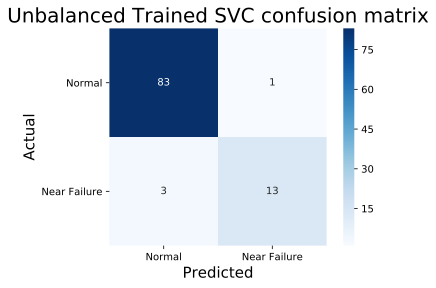

In [16]:
# Print confusion matrix for SVC

from sklearn.metrics import confusion_matrix
from sklearn import metrics

y_test = RUL_df['20_cycles_to_failure']
y_pred = naive_svc_predicted_class

svc_confusion = confusion_matrix(y_test, y_pred)
plt.figure(dpi=150)
cm = sns.heatmap(svc_confusion, cmap=plt.cm.Blues, annot=True, square=True,
            xticklabels=['Normal', 'Near Failure'],
            yticklabels=['Normal', 'Near Failure'])
cm.set_yticklabels(labels = ['Normal', 'Near Failure'], rotation=0)

plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual', fontsize=15)
plt.title('Unbalanced Trained SVC confusion matrix', fontsize=20);

svc_accuracy = metrics.accuracy_score(y_test, y_pred)
svc_recall = metrics.recall_score(y_test, y_pred)
svc_f1 = metrics.f1_score(y_test, y_pred).round(3)
print('Unbalanced Trained SVC Accuracy: {}'.format(svc_accuracy))
print('Unbalanced Trained SVC Recall: {}'.format(svc_recall))
print('Unbalanced Trained SVC F1: {}'.format(svc_f1))

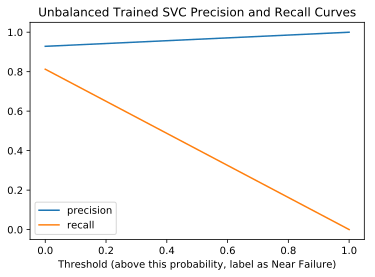

In [17]:
# Plot the precision vs. recall curve

from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, y_pred)

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc ='lower left')
plt.xlabel('Threshold (above this probability, label as Near Failure)');
plt.title('Unbalanced Trained SVC Precision and Recall Curves');

In [18]:
t = naive_test.columns == 'gbc_pred_20_cycles_to_failure'
ind = [i for i, x in enumerate(t) if x]

naive_gbc_predicted_class = []

for i in range(naive_test.unit_number.min(), naive_test.unit_number.max()+1):
    gbc_npredicted_class=naive_test[naive_test.unit_number==i].iloc[naive_test[naive_test.unit_number==i].cycles.max()-1]
    naive_gbc_predicted_class.append(gbc_npredicted_class['gbc_pred_20_cycles_to_failure'].astype(int))

print(len(naive_gbc_predicted_class))
naive_gbc_predicted_class[0:10]


100


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Unbalanced Trained GBC Accuracy: 0.95
Unbalanced Trained GBC Recall: 0.75
Unbalanced Trained GBC F1: 0.828


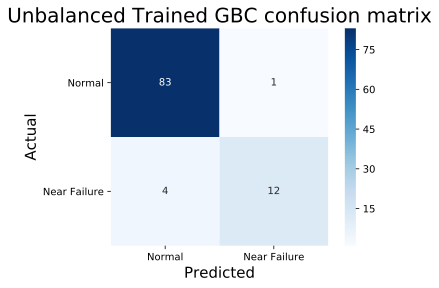

In [19]:
# Print confusion matrix for SVC

from sklearn.metrics import confusion_matrix
from sklearn import metrics

y_test = RUL_df['20_cycles_to_failure']
y_pred = naive_gbc_predicted_class

svc_confusion = confusion_matrix(y_test, y_pred)
plt.figure(dpi=150)
cm = sns.heatmap(svc_confusion, cmap=plt.cm.Blues, annot=True, square=True,
            xticklabels=['Normal', 'Near Failure'],
            yticklabels=['Normal', 'Near Failure'])
cm.set_yticklabels(labels = ['Normal', 'Near Failure'], rotation=0)

plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual', fontsize=15)
plt.title('Unbalanced Trained GBC confusion matrix', fontsize=20);

svc_accuracy = metrics.accuracy_score(y_test, y_pred)
svc_recall = metrics.recall_score(y_test, y_pred)
svc_f1 = metrics.f1_score(y_test, y_pred).round(3)
print('Unbalanced Trained GBC Accuracy: {}'.format(svc_accuracy))
print('Unbalanced Trained GBC Recall: {}'.format(svc_recall))
print('Unbalanced Trained GBC F1: {}'.format(svc_f1))

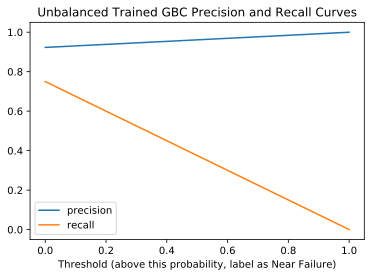

In [20]:
# Plot the precision vs. recall curve

from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, y_pred)

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc ='lower left')
plt.xlabel('Threshold (above this probability, label as Near Failure)');
plt.title('Unbalanced Trained GBC Precision and Recall Curves');

In [21]:
# Now let's balance the training data with SMOTE and see if we can improve our predictions

# Review label counts before oversampling

target_count = pd.DataFrame(y)
target_count = target_count['20_cycles_to_failure'].value_counts()

# Print class balance

print(f"Class 0: 'Normal': {target_count[0]}")
print(f"Class 1: 'Near Failure': {target_count[1]}")
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 'Normal': 18531
Class 1: 'Near Failure': 2100
Proportion: 8.82 : 1
Percentage of Majority Class: 89.82


In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_SMOTE, y_SMOTE = smote.fit_sample(X, y.ravel())

# Revisit label counts following SMOTE oversampling

target_count = pd.DataFrame(y_SMOTE)
target_count = target_count[0].value_counts()

# Print class balance

print(f"Class 0: 'Normal': {target_count[0]}")
print(f"Class 1: 'Near Failure': {target_count[1]}")
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 'Normal': 18531
Class 1: 'Near Failure': 18531
Proportion: 1.0 : 1
Percentage of Majority Class: 50.0


In [23]:
hyperparameter_grid_search(X_SMOTE, y_SMOTE, classification_models, hyperparameter_grid, scoring='f1')

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


[[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=5, p=2,
             weights='uniform'), {'n_neighbors': 2}, 0.9804929948067485],
 [SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False),
  {'kernel': 'rbf', 'gamma': 0.1, 'C': 6},
  0.9816602210247052],
 [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=42,
              splitter='best'), {'max_depth': 4}, 0.9607796104427511],
 [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gin

In [24]:
tuned_classification_models = {
    'K-Nearest Neighbors Classifier': KNeighborsClassifier(n_neighbors=2),
    'Support Vector Classifier': SVC(kernel='rbf', C=6, 
                                  gamma=0.1), 
    'Decision Tree Classifier': DecisionTreeClassifier(max_depth=4),
    'Random Forest Classifier': RandomForestClassifier(max_depth=4, n_estimators=95), 
    'Gradient Boosting Classifier': GradientBoostingClassifier(learning_rate=0.1, max_depth=4)
}

In [25]:
# Create function to evaluate cross validated model scores

from sklearn.model_selection import cross_val_score

def model_cross_validation(X, y, models, scoring):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results_list = []
    
    for model in models.values():
        cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring=scoring)
        results_list.append((model, cv_score.mean()))
        
    return results_list

In [26]:
model_cross_validation(X_SMOTE, y_SMOTE, tuned_classification_models, scoring='recall')

[(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=2, p=2,
             weights='uniform'), 0.9964261631827377),
 (SVC(C=6, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 0.994335805799056),
 (DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'), 0.9679703304113282),
 (RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=4, max_features='auto', max_leaf_nodes=None,
              min_impurity_d

In [27]:
# Let's see compare predictions from our optimized Support Vector Classifier and Gradient Boosted Classifier

# Split into train and test matrices

X_train = train.values[:,1:18]
y_train = train.values[:,20]
X_test = test.values[:,1:18]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = SVC(kernel='rbf', C=6, gamma=0.1, probability=True)
svc = svc.fit(X_train_scaled, y_train)
svc_pred = svc.predict(X_test_scaled)

gbc = GradientBoostingClassifier(learning_rate=0.1, max_depth=4)
gbc = gbc.fit(X_train_scaled, y_train)
gbc_pred = gbc.predict(X_test_scaled)

svc_score = svc.predict(X_test_scaled)
gbc_score = gbc.predict(X_test_scaled)

In [28]:
test = pd.merge(test, test.groupby('unit_number', as_index=False)['time_in_cycles'].max(), how='left', 
                   on='unit_number')
test.rename(columns={"time_in_cycles_x": "cycles", "time_in_cycles_y": "maxcycles"}, inplace=True)

test['svc_pred_20_cycles_to_failure'] = svc_score
test['gbc_pred_20_cycles_to_failure'] = gbc_score
test['svc_pred_20_cycles_to_failure'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: svc_pred_20_cycles_to_failure, dtype: float64

In [29]:
test.head()

,unit_number,cycles,operational_setting_1,operational_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21,maxcycles,svc_pred_20_cycles_to_failure,gbc_pred_20_cycles_to_failure
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,...,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,31,0.0,0.0
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,...,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,31,0.0,0.0
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,...,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,31,0.0,0.0
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,...,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,31,0.0,0.0
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,...,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,31,0.0,0.0


In [30]:
t = test.columns == 'svc_pred_20_cycles_to_failure'
ind = [i for i, x in enumerate(t) if x]

svc_predicted_class = []

for i in range(test.unit_number.min(), test.unit_number.max()+1):
    svc_npredicted_class=test[test.unit_number==i].iloc[test[test.unit_number==i].cycles.max()-1]
    svc_predicted_class.append(svc_npredicted_class['svc_pred_20_cycles_to_failure'].astype(int))

print(len(svc_predicted_class))
svc_predicted_class[0:10]

100


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

SVC Accuracy: 0.97
SVC Recall: 0.875
SVC F1: 0.903


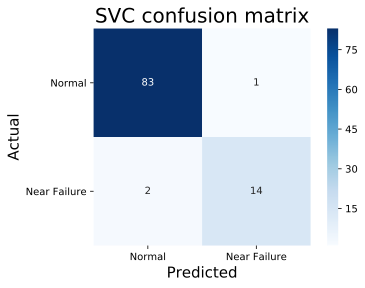

In [31]:
# Print confusion matrix for SVC

from sklearn.metrics import confusion_matrix
from sklearn import metrics

y_test = RUL_df['20_cycles_to_failure']
y_pred = svc_predicted_class

svc_confusion = confusion_matrix(y_test, y_pred)
plt.figure(dpi=150)
cm = sns.heatmap(svc_confusion, cmap=plt.cm.Blues, annot=True, square=True,
            xticklabels=['Normal', 'Near Failure'],
            yticklabels=['Normal', 'Near Failure'])
cm.set_yticklabels(labels = ['Normal', 'Near Failure'], rotation=0)

plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual', fontsize=15)
plt.title('SVC confusion matrix', fontsize=20);

svc_accuracy = metrics.accuracy_score(y_test, y_pred)
svc_recall = metrics.recall_score(y_test, y_pred)
svc_f1 = metrics.f1_score(y_test, y_pred).round(3)
print('SVC Accuracy: {}'.format(svc_accuracy))
print('SVC Recall: {}'.format(svc_recall))
print('SVC F1: {}'.format(svc_f1))

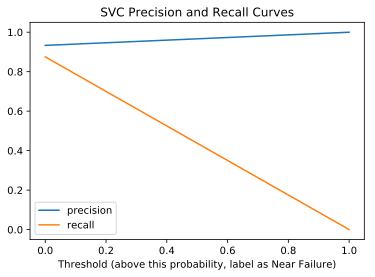

In [32]:
# Plot the precision vs. recall curve

from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, y_pred)

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc ='lower left')
plt.xlabel('Threshold (above this probability, label as Near Failure)');
plt.title('SVC Precision and Recall Curves');

In [33]:
t = test.columns == 'gbc_pred_20_cycles_to_failure'
ind = [i for i, x in enumerate(t) if x]

gbc_predicted_class = []

for i in range(test.unit_number.min(), test.unit_number.max()+1):
    gbc_npredicted_class=test[test.unit_number==i].iloc[test[test.unit_number==i].cycles.max()-1]
    gbc_predicted_class.append(gbc_npredicted_class['gbc_pred_20_cycles_to_failure'].astype(int))

print(len(gbc_predicted_class))
gbc_predicted_class[0:10]

100


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

GBC Accuracy: 0.97
GBC Recall: 0.875
GBC F1: 0.903


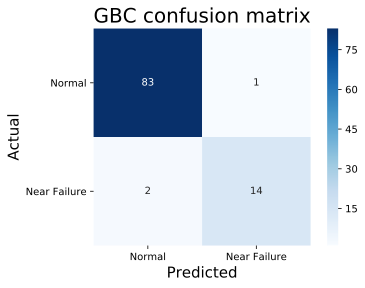

In [34]:
# Print confusion matrix for GBC

from sklearn.metrics import confusion_matrix
from sklearn import metrics

y_test = RUL_df['20_cycles_to_failure']
y_pred = gbc_predicted_class

svc_confusion = confusion_matrix(y_test, y_pred)
plt.figure(dpi=150)
cm = sns.heatmap(svc_confusion, cmap=plt.cm.Blues, annot=True, square=True,
            xticklabels=['Normal', 'Near Failure'],
            yticklabels=['Normal', 'Near Failure'])
cm.set_yticklabels(labels = ['Normal', 'Near Failure'], rotation=0)

plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual', fontsize=15)
plt.title('GBC confusion matrix', fontsize=20);

gbc_accuracy = metrics.accuracy_score(y_test, y_pred)
gbc_recall = metrics.recall_score(y_test, y_pred)
gbc_f1 = metrics.f1_score(y_test, y_pred).round(3)
print('GBC Accuracy: {}'.format(gbc_accuracy))
print('GBC Recall: {}'.format(gbc_recall))
print('GBC F1: {}'.format(gbc_f1))

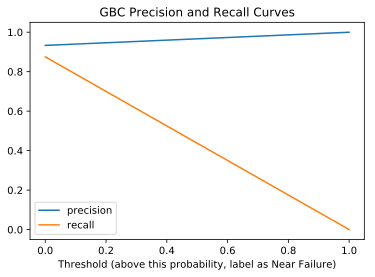

In [35]:
# Plot the precision vs. recall curve

from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, y_pred)

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc ='lower left')
plt.xlabel('Threshold (above this probability, label as Near Failure)');
plt.title('GBC Precision and Recall Curves');

In [58]:
# Let's analyze results and visualize with PCA

from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_transform = pca.transform(X_scaled)

cvs = cross_val_score(GradientBoostingClassifier(random_state=42), X_transform, y, cv=5, scoring='f1')
cvs.mean()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.8486175774237565

In [55]:
from itertools import cycle

def PCA_plot(data, target, target_names):
    colors = cycle(['blue','red'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(7,5))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='white', alpha=0.2)
    plt.legend()

In [56]:
# Plot out principal components

print(pca.explained_variance_ratio_) # Nearly 70% of variance is explained by two components!

PCA_plot(X_transf, target=y_train, target_names=['Normal', 'Near Failure'])
plt.legend(fontsize=15)
plt.figure(figsize=[10,10]);

[0.55785606 0.12749143]


<Figure size 720x720 with 0 Axes>

In [52]:
# Feature importance from PCA

pca_df = pd.DataFrame(pca.components_, index = ['PC1','PC2'])

feat_imp = list(zip(X.columns, pca_df.iloc[0, :].values))
feat_imp

[('cycles', 0.23348367396544487),
 ('operational_setting_1', 0.0020720826994571604),
 ('operational_setting_2', 0.005140242742273102),
 ('sensor_measurement_2', 0.2656256159572511),
 ('sensor_measurement_3', 0.25355232747185447),
 ('sensor_measurement_4', 0.2931650669810384),
 ('sensor_measurement_7', -0.2897317753399077),
 ('sensor_measurement_8', 0.27091865722876357),
 ('sensor_measurement_9', 0.1101477981026418),
 ('sensor_measurement_11', 0.300805846581385),
 ('sensor_measurement_12', -0.2956447646394178),
 ('sensor_measurement_13', 0.27060550416763046),
 ('sensor_measurement_14', 0.07200898884705759),
 ('sensor_measurement_15', 0.27928690736781775),
 ('sensor_measurement_17', 0.26249043067622924),
 ('sensor_measurement_20', -0.2751881995017613),
 ('sensor_measurement_21', -0.2761442156260667)]